## Survival analysis

In [1]:
import lifelines
import numpy as np, scipy, pandas as pd
import seaborn as sns
import torch
import pickle
import os
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
from lifelines import CoxTimeVaryingFitter

In [3]:
from datasets import *
from utils import *
from models import *

Generate data.

First, we define some hyper parameters. For example, maximum observed time, coefficients for CoxTimeVaryingFitter etc.

In [4]:
max_obs = 15000
max_duration = 100000
num_series = 250
num_var = 30
train_size = 220

#rho coefficient is needed to adjust death times
rho = 1.88

#coeffs for hazard function computation
coeffs = np.zeros(num_var + 1)
coeffs[-1] = 0.5

#kwargs for ts generation
kw = {"start_from": 0, "num_anomalies": 10, "anomaly_len_low": 20, "anomaly_len_high":50}

#params for anomaly detection
window_cor_size = 10
window_conv_size = 5
threshold = 0.009

In [5]:
survival_data, durations = get_survival_data(num_series, num_var, max_obs=max_obs, coeffs=coeffs, rho=1.88,
                                  start_from=0, num_anomalies=10, anomaly_len_low=20, anomaly_len_high=50)

In [7]:
survival_data_train = survival_data[:train_size]
survival_data_test = survival_data[train_size:]

In [8]:
sur_df_train = transform_to_long(survival_data[:train_size], max_obs)
sur_df_test = transform_to_long(survival_data[train_size:], max_obs)

In [9]:
sur_df_train.head()

,id,start,stop,1,2,3,4,5,6,7,...,23,24,25,26,27,28,29,30,anomaly_counter,event
0,1,0,1,-0.666147,-1.292631,0.143066,-1.617122,-1.028870,-1.006820,0.327560,...,0.281943,-1.523800,0.460489,-0.292273,0.015548,-1.360142,0.547546,-0.818705,0.0,0.0
1,1,1,2,-1.049397,-1.087161,0.153469,-1.276597,-1.186111,-0.970642,0.049919,...,0.277625,-0.940939,0.033070,0.286932,0.447723,-1.080542,0.301121,-1.165081,0.0,0.0
2,1,2,3,-0.769365,-0.787209,0.591519,-1.065646,-1.102099,-1.151703,0.094880,...,0.458988,-0.804782,-0.027769,0.027673,0.023581,-1.206123,0.164528,-0.919964,0.0,0.0
3,1,3,4,-0.921205,-1.535383,-0.151246,-1.824311,-0.900864,-1.400377,-0.153549,...,-0.391761,-0.964428,0.908503,0.323517,0.376397,-0.794511,-0.173406,-1.604811,0.0,0.0
4,1,4,5,-1.267073,-0.874861,-0.261036,-1.058005,-1.374881,-0.721268,-0.094706,...,1.047654,-0.687868,0.457461,0.551306,0.618857,-0.724751,0.894550,-0.866230,0.0,0.0


Survival analysis.

In [10]:
ctv = CoxTimeVaryingFitter(penalizer=0.1)
ctv.fit(sur_df_train, id_col="id", start_col='start', stop_col='stop', event_col="event", show_progress=True)

Iteration 1: norm_delta = 1.35347, step_size = 0.95000, ll = -930.87431, newton_decrement = 53.42381, seconds_since_start = 3.4
Iteration 2: norm_delta = 0.10730, step_size = 0.95000, ll = -877.09142, newton_decrement = 0.32621, seconds_since_start = 6.7
Iteration 3: norm_delta = 0.00629, step_size = 0.95000, ll = -876.74993, newton_decrement = 0.00108, seconds_since_start = 9.9
Iteration 4: norm_delta = 0.00033, step_size = 1.00000, ll = -876.74796, newton_decrement = 0.00000, seconds_since_start = 13.2
Iteration 5: norm_delta = 0.00000, step_size = 1.00000, ll = -876.74791, newton_decrement = 0.00000, seconds_since_start = 16.5
Convergence completed after 5 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 2523657 periods, 220 subjects, 201 events>

In [12]:
ctv.print_summary()

<lifelines.CoxTimeVaryingFitter: fitted with 2523657 periods, 220 subjects, 201 events>
         event col = 'event'
         penalizer = 0.1
number of subjects = 220
 number of periods = 2523657
  number of events = 201
    log-likelihood = -876.75
  time fit was run = 2019-04-15 13:07:32 UTC

---
                 coef exp(coef)  se(coef)     z      p  -log2(p)  lower 0.95  upper 0.95
1                0.03      1.03      0.09  0.34   0.73      0.45       -0.15        0.21
2               -0.05      0.95      0.09 -0.52   0.60      0.73       -0.23        0.13
3                0.05      1.06      0.09  0.58   0.56      0.83       -0.13        0.24
4               -0.06      0.95      0.09 -0.60   0.55      0.86       -0.24        0.13
5               -0.21      0.81      0.09 -2.22   0.03      5.24       -0.39       -0.02
6                0.12      1.12      0.09  1.23   0.22      2.20       -0.07        0.30
7               -0.04      0.96      0.09 -0.46   0.64      0.63       -0.23 

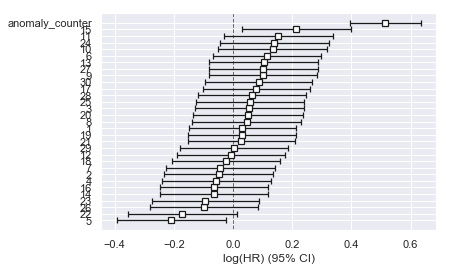

In [18]:
plot = ctv.plot()
fig = plot.get_figure()
fig.savefig("coefs.pdf")

Make some predictions.

In [33]:
test_df = sur_df_test.loc[sur_df_test.id == 5].drop(['id', 'start', 'stop', 'event'], axis=1)
partial_hazard = ctv.predict_partial_hazard(test_df)
indices = np.argwhere(test_df['anomaly_counter'].values[1::] - test_df['anomaly_counter'].values[:-1] == 1)
max_val = partial_hazard.max().values

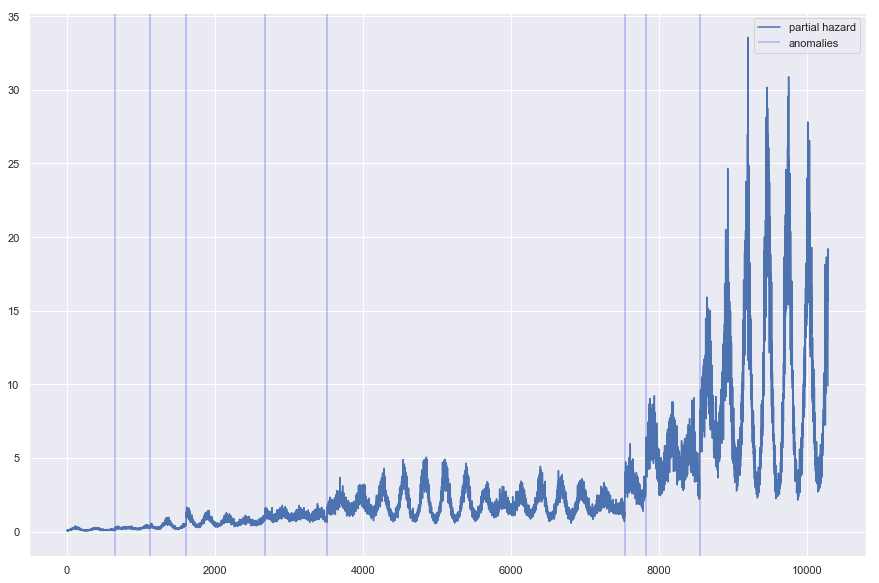

In [34]:
plt.figure(figsize=(15, 10))
plt.plot(np.arange(len(partial_hazard)), partial_hazard,label='partial hazard') 
plt.vlines(indices, -0.05 * max_val, 1.05 * max_val, color=((0, 0, 1, 0.25)), label='anomalies')
plt.ylim([-0.05 * max_val, 1.05 * max_val])
plt.legend()
plt.savefig('haz.pdf')
plt.show()

Let's now test our model on this toy data.

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() is True else 'cpu')

In [22]:
test_ts = test_df.drop(['anomaly_counter'], axis=1).values.T
test_cor_list = get_cross_correlation_list(test_ts, window_size=window_cor_size)
test_data = generate_tensor_dataset(cross_cor=test_cor_list, test=True)

In [23]:
ae_model = UnetAE(in_channels=window_conv_size, num_features=num_var, 
                         BatchNorm=False, Attention=True, multidimensional=False)

In [24]:
ae_model.load_state_dict(torch.load("models//unet_noBN_ws10_attn_cat.pth"))
ae_model.to(device)
ae_model.eval()

UnetAE(
  (down_path): Sequential(
    (0): ConvBlock(
      (layers_list): Sequential(
        (0): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.01)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): LeakyReLU(negative_slope=0.01)
      )
    )
    (1): ConvBlock(
      (layers_list): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.01)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): LeakyReLU(negative_slope=0.01)
      )
    )
    (2): ConvBlock(
      (layers_list): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.01)
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): LeakyReLU(negative_slope=0.01)
      )
    )
    (3): ConvBlock(


In [25]:
test_scores = get_mse_scores(ae_model, test_data, device, batch_size=64)
test_scores = test_scores.numpy().ravel()

100%|████████████████████████████████████████████████████████████████████████████████| 161/161 [00:08<00:00, 18.86it/s]


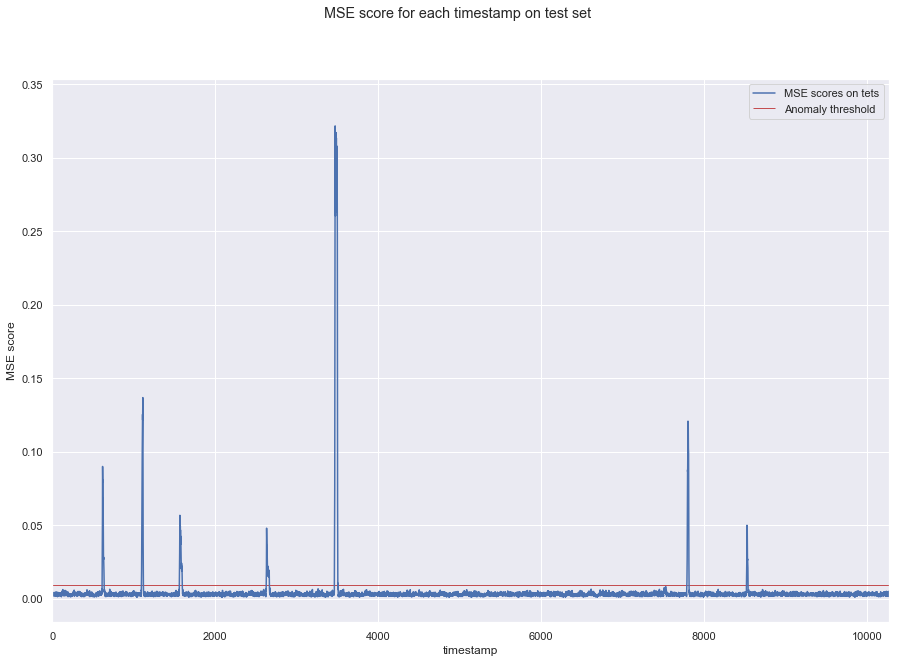

In [26]:
draw_mse_scores(test_scores, label="MSE scores on tets", title="MSE score for each timestamp on test set", threshold=threshold, path='mse_sur_test.pdf')

In [28]:
predictions = test_scores > threshold

In [29]:
anomaly_counter = np.concatenate((np.zeros(window_conv_size + window_cor_size), create_anomaly_series(predictions)))
anomaly_counter = pd.Series(anomaly_counter, name='anomaly_counter')

In [30]:
test_df_predicted = pd.concat((test_df.drop('anomaly_counter', axis=1), anomaly_counter), axis=1)
partial_hazard_predicted = ctv.predict_partial_hazard(test_df_predicted)
indices_predicted = np.argwhere(test_df_predicted['anomaly_counter'].values[1::] - \
                                test_df_predicted['anomaly_counter'].values[:-1] == 1)
max_val_predicted = partial_hazard_predicted.cumsum().max().values 

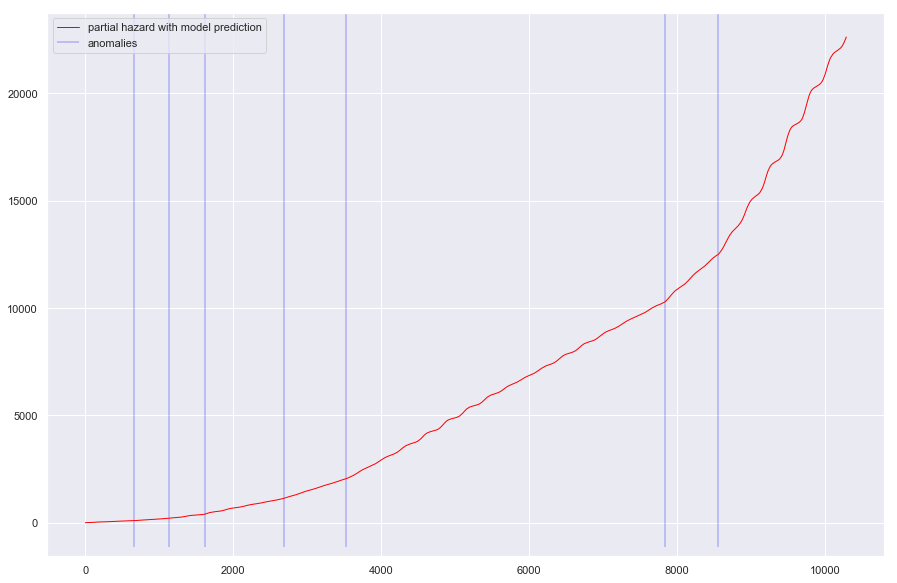

In [31]:
plt.figure(figsize=(15, 10))
plt.plot(np.arange(len(partial_hazard_predicted)), partial_hazard_predicted.cumsum(),
         label='partial hazard with model prediction', linewidth=1, color='red')
plt.vlines(indices_predicted, -0.05 * max_val_predicted, 1.05 * max_val_predicted, color=((0, 0, 1, 0.25)), label='anomalies')
plt.ylim([-0.05 * max_val, 1.05 * max_val_predicted])

plt.legend()
plt.savefig('pred_cumsum_haz.pdf')
plt.show()